![image](https://www.ewatercycle.org/assets/logo.png)

# Case study 0: Hello worlds. Run two models on the same forcing data and compare output (discharge)
This notebooks demonstrates how to use models in eWaterCycle by showing how to run two different models for the same region (Merrimack) and on the same forcing data (ERA5: 1990).

The models used in this notebook are:

- WFlow (details)
- LISFLood (details)

## Import statements
We'll be using the following modules

In [1]:
import logging
logger = logging.getLogger('grpc4bmi.bmi_grpc_client')
logger.setLevel(logging.WARNING)

In [ ]:
from cftime import num2date
import pandas as pd
import xarray as xr
from pathlib import Path

from ewatercycle import CFG
from ewatercycle.models import Wflow, Lisflood
from ewatercycle.analysis import hydrograph
from ewatercycle.observation.grdc import get_grdc_data
from ewatercycle.models.lisflood import LisfloodParameterSet

## eWaterCycle config file
This notebook was run on cartesius.surfsara.nl as it has a big subset of ERA5 data files and can run models in Singularity containers. 

```yml
grdc_location: '/projects/0/wtrcycle/comparison/GRDC/GRDC_GCOSGTN-H_27_03_2019'
container_engine: 'singularity'
output_dir: '/scratch/shared/ewatercycle'
wflow.singularity_image: 'ewatercycle-wflow-grpc4bmi.sif'
lisflood.singularity_image: 'ewatercycle-lisflood-grpc4bmi.sif'
```

In [3]:
# Load config file
CFG.load_from_file('./ewatercycle.yaml')

## Observation

In [5]:
# Get grdc observations at 4147380 station related to Merrimack
ds = get_grdc_data("4147380", '1990-01-01', '1990-12-31', data_home=CFG["grdc_location"])

# Get lat/lon of the station
station_lat = ds.attrs["grdc_latitude_in_arc_degree"]
station_lon = ds.attrs["grdc_longitude_in_arc_degree"]

# Convert it to dataframe and rename it to GRDC
observations = ds.to_dataframe().rename(columns={"streamflow": "GRDC"})
observations.index = observations.index.date
observations.index.name = "time"
observations

,GRDC
time,
1990-01-01,119.214
1990-01-02,136.204
1990-01-03,131.107
1990-01-04,133.655
1990-01-05,139.035
...,...
1990-12-27,668.276
1990-12-28,512.534
1990-12-29,419.089


## Wflow

In [19]:
# Create wflow instance
model = Wflow()

# wflow_ERA5_*_1990_1990.nc data can be copied 
# from /projects/0/wtrcycle/comparison/forcing/wflow to cfg_dir/inmaps
# Create config file and start up container
cfg_file, cfg_dir = model.setup(
    cfg_dir='/projects/0/wtrcycle/comparison/wflow_parameterset/calibrated_parameterset/merrimack/',
    cfg_file='./wflow_sbm_Merrimack_ERA5_warmup.ini',
    API={"RiverRunoff": "2, m^3/s"}
)
print(cfg_dir)

Working directory created: /scratch/shared/ewatercycle/wflow_20210422_170544
Created /scratch/shared/ewatercycle/wflow_20210422_170544/wflow_ewatercycle.ini.
Running ewatercycle-wflow-grpc4bmi.sif singularity container on port 40456
Started wflow container with working directory /scratch/shared/ewatercycle/wflow_20210422_170544
/scratch/shared/ewatercycle/wflow_20210422_170544


In [20]:
# Initialize
model.initialize(str(cfg_file))

# Get metadata
print(model.output_var_names)

('RiverRunoff',)


In [21]:
# Assumption: model coordinates equal to station coordinates
model_longitude = station_lon
model_latitude = station_lat

# Run the model and get RiverRunoff values
discharge = []
while model.time < model.end_time:
    model.update()
    # Get RiverRunoff as xarray
    output = model.get_value_as_xarray('RiverRunoff')
    # Get RiverRunoff at one location
    discharge_at_pixel = output.sel(latitude=model_latitude, longitude=model_longitude, method='nearest')
    discharge.append(discharge_at_pixel)


In [22]:
# Concatenate timeseries
wflow_discharge = xr.concat(discharge, dim='time')

# Convert xarray to a dataframe
wflow_discharge["time"] = wflow_discharge["time"].dt.strftime('%Y-%m-%d')
wflow = wflow_discharge.to_dataframe().rename(columns={"RiverRunoff": "wflow"})
wflow = wflow.drop(['longitude','latitude'], axis=1)
wflow.index = pd.to_datetime(wflow_discharge.time.values)
wflow.index = wflow.index.date
wflow.index.name = "time"
wflow

,wflow
time,
1990-01-01,0.174929
1990-01-02,0.598014
1990-01-03,0.935433
1990-01-04,1.107896
1990-01-05,2.972760
...,...
1990-12-27,586.897156
1990-12-28,508.736084
1990-12-29,448.062897


In [9]:
# Finalize the model
model.finalize()

# Stop the model
del(model)

## Lisflood

In [10]:
# Create an object holding directories needed by lisflood
parameterset = LisfloodParameterSet(
    root=Path('/projects/0/wtrcycle/comparison/lisflood_input/Lisflood01degree_masked'),
    mask=Path('/projects/0/wtrcycle/comparison/recipes_auxiliary_datasets/LISFLOOD/model_mask.nc'),
    config_template=Path('/projects/0/wtrcycle/comparison/lisflood_input/settings_templates/settings_lisflood.xml'),
    lisvap_config_template=Path('/projects/0/wtrcycle/comparison/lisflood_input/settings_templates/settings_lisvap.xml'),
)

In [11]:
# Create lisflood instance
model = Lisflood()

# lisflood_ERA5_*_1990_1990.nc data can be copied 
# from /projects/0/wtrcycle/comparison/forcing/lisflood
forcing_dir = Path('lisflood_forcing_data')

# Setup model
config_file, config_dir = model.setup(forcing_dir, parameterset)
print(config_dir)

# Run lisvap
lisvap_results = model.run_lisvap(forcing_dir)

Running ewatercycle-lisflood-grpc4bmi.sif singularity container on port 48535
/scratch/shared/ewatercycle/lisflood_20210422_160047


In [12]:
# Initialize
model.initialize(str(config_file))

# Get metadata
print(model.output_var_names)

('Discharge',)


In [13]:
# pixel coordinate (-71.35, 42.65) related to Merrimack given by lisflood modelers
model_longitude = -71.35
model_latitude = 42.65

# Run the model and get Discharge values
discharge = []
while model.time < model.end_time:
    model.update()
    # Get Discharge values as xarray
    output = model.get_value_as_xarray('Discharge')
    # Get Discharge at one location
    discharge_at_pixel = output.sel(latitude=model_latitude, longitude=model_longitude, method='nearest')
    discharge.append(discharge_at_pixel)

In [15]:
# Stop the model
del model.bmi

In [14]:
# Concatenate timeseries
lisflood_discharge = xr.concat(discharge, dim='time')

# Convert xarray to a dataframe
lisflood_discharge["time"] = lisflood_discharge["time"].dt.strftime('%Y-%m-%d')
lisflood = lisflood_discharge.to_dataframe().rename(columns={"Discharge": "lisflood"})
lisflood = lisflood.drop(['longitude','latitude'], axis=1)
lisflood.index = pd.to_datetime(lisflood_discharge.time.values)
lisflood.index = lisflood.index.date
lisflood.index.name = "time"
lisflood

,lisflood
time,
1990-01-03,9.061750
1990-01-04,15.274644
1990-01-05,30.082788
1990-01-06,51.922786
1990-01-07,84.816580
...,...
1990-12-27,318.036922
1990-12-28,398.285179
1990-12-29,491.402610


## Hydrograph

/home/fakhereh/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [0 1] contained NaN values and the row(s) have been removed (Rows are zero indexed).


(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, xlabel='time', ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

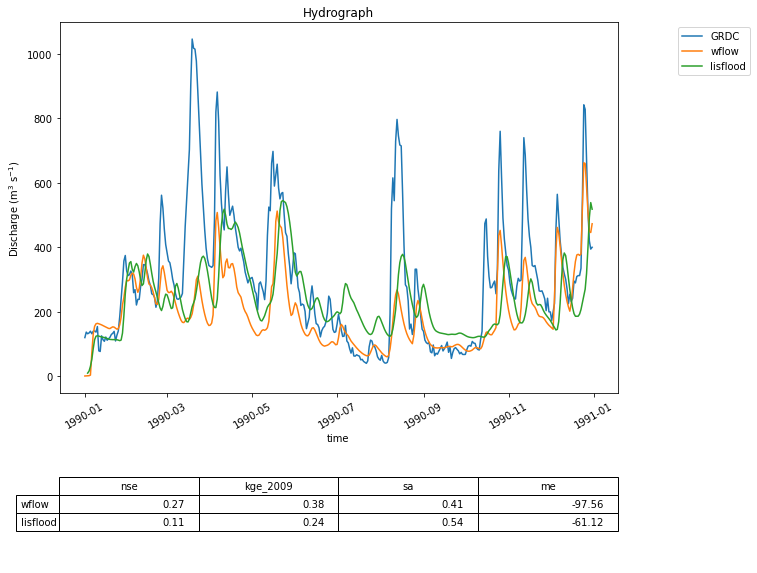

In [23]:
# Combine simulated and observed values to one dataframe according to time axis
hydro_data = pd.concat([wflow, lisflood, observations], axis=1)

# Plot hydrograph and show metrics
hydrograph(hydro_data, reference='GRDC')